In [63]:
from __future__ import print_function, division
import numpy as np
import pickle as pkl
import glob 
import sncosmo
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
templFiles = glob.glob("meanspec*")
templFiles

['meanspecIb.p', 'meanspecIc.p', 'meanspecIcbl.p', 'meanspecIIb.p']

In [3]:
subtypes = {"Ib": None, "Ic": None, "Icbl": None, "IIb": None}

for st in subtypes:
    subtypes[st] = pkl.load(open("meanspec" + st + ".p", "rb"))
subtypes


{'IIb': {'-10': (array([ 2501.68994141,  2505.08007812,  2508.47998047, ...,  9966.20996094,
           9979.71972656,  9993.24023438], dtype=float32),
   array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
   array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
   '7'),
  '0': (array([ 2501.68994141,  2505.08007812,  2508.47998047, ...,  9966.20996094,
           9979.71972656,  9993.24023438], dtype=float32),
   array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
   array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
   '8'),
  '15': (array([ 2501.68994141,  2505.08007812,  2508.47998047, ...,  9966.20996094,
           9979.71972656,  9993.24023438], dtype=float32),
   array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
   array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32),
   '11'),
  '20': (array([ 2501.68994141,  2505.08007812,  2508.47998047, ...,  9966.20996094,
           9979.71972656,  9993.24023438], dtype=float32),
   array([ 0.,  0

In [105]:
subtypesArray = {}
subtypesArrayErr = {}
subtypesPhases = {}
subtypesW = {}
for st in subtypes:   
    subtypesPhases[st] = np.sort(np.array(subtypes[st].keys()).astype(float)) + 10
    subtypesW[st] = np.array(subtypes[st]['0'][0])
    print (st, subtypesPhases[st], len(subtypesPhases[st]))
    subtypesArray[st] = np.empty((len(subtypesPhases[st]), len(subtypesW[st])))
    subtypesArrayErr[st] = np.empty((len(subtypesPhases[st]), len(subtypesW[st])))
    for i, phase in enumerate(subtypesPhases[st]):
        phs = "%d"%phase
        if phs == '5': phs = '05'
        subtypesArray[st][i] =  subtypes[st][phs][1]
        subtypesArrayErr[st][i] =  subtypes[st][phs][2]
                                 

Ic [  0.   5.  10.  15.  20.  25.  30.] 7


KeyError: '25'

In [66]:
model = {}

In [67]:
def plotSubtype(st):
    fig = pl.figure(figsize = (10,5))
    fig.add_subplot(121)
    pl.imshow(subtypesArray[st], aspect=100)
    pl.title(st)
    fig.add_subplot(122)
    for i, flx in enumerate(subtypesArray[st]):
        pl.errorbar(subtypesW[st], flx + i, yerr = subtypesArrayErr[st][i])
        pl.text(9500, i, "phase %d"%subtypesPhases[st][i])
        pl.xlabel("wavelength")
        pl.ylabel("relative flux")
    source = sncosmo.TimeSeriesSource(subtypesPhases[st], subtypesW[st], subtypesArray[st])
    model[st] = sncosmo.Model(source)

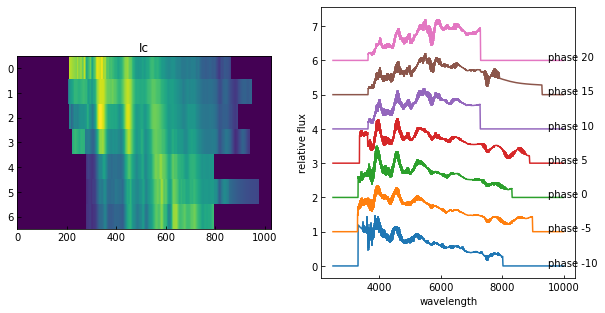

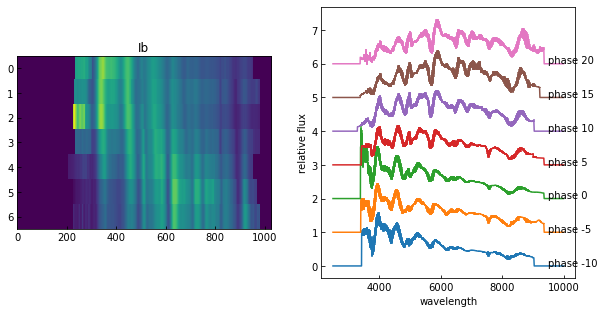

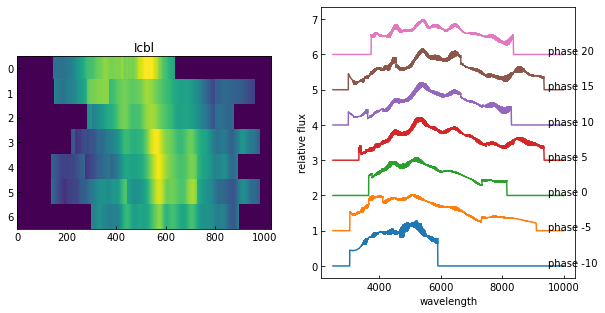

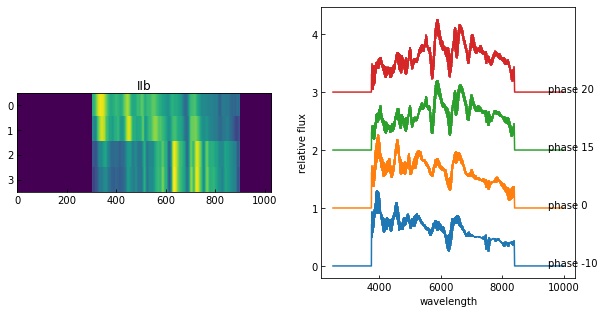

In [68]:
for st in subtypes:
    plotSubtype(st)
    

In [69]:
model

{'IIb': <sncosmo.models.Model at 0x108d6b950>,
 'Ib': <sncosmo.models.Model at 0x10bd83ad0>,
 'Ic': <sncosmo.models.Model at 0x10620b650>,
 'Icbl': <sncosmo.models.Model at 0x107a99f50>}

In [101]:
import sncosmo
from astropy.table import Table
obs = Table({'time': np.linspace(56176.19,56230.19,100),
             'band': ['desg']*100,
             'gain': [1.]*100,
             'skynoise': [191.27]*100,
             'zp': [30.]*100,
             'zpsys':['ab']*100})
#print (obs)

In [102]:
params = {'z': 0.4, 't0': 56200.0}#, 'x0':1.e-5, 'x1': 0.1, 'c': -0.1}

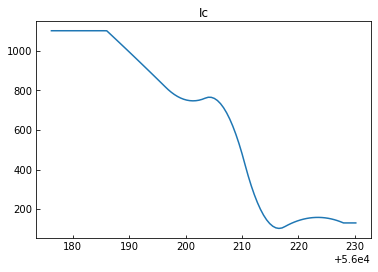

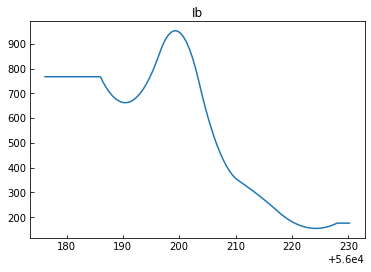

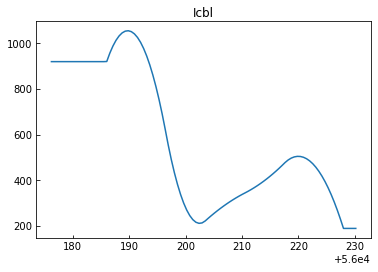

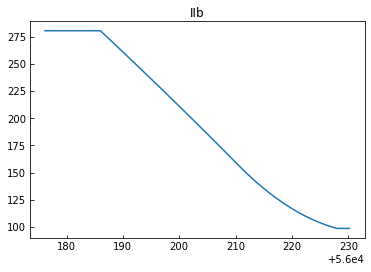

In [103]:
for st in subtypes:
    lcs = sncosmo.realize_lcs(obs, model[st], [params])
    #print (lcs)
    pl.figure()
    pl.title(st)
    pl.errorbar(lcs[0]['time'].quantity, lcs[0]['flux'].quantity*1e-17, yerr = lcs[0]['fluxerr'].quantity*1e-17)
    